# 0. Marking and Guidelines
---
***IMPORTANT***

> The **attendance** and **active participation** in the **lab sessions** is **strongly recommended** and will be considered for grading.
>
> Save a copy of this notebook into your Drive before you start
>
> Please attempt all the **questions** marked for your **group** (Part II ✅ | Part III/MPhil ✅).
>
> Please, provide your answers in a **new cell below the question cell**. You can make as many new cells as you need.

Please submit a `.zip` file, containing both parts, consisting of:
1. A text file with a **publicly** visible link to your notebooks in GitHub.
2. A **downloaded copy** (`.ipynb`) of your notebooks or your zipped cloned GitHub repo. You may treat these as a report---we will not be re-executing the code you used to produce the answers unless required.


Feel free to attempt more in case you find yourself enjoying the material!
If you have any questions, please ask them to the teaching assistants.
Are you interested in knowing more about federated learning and related topics? Reach out to the teaching assistants for additional resources and ask more about the current research projects.

## Dependencies
---


In [1]:
# `pip` could produce some errors. Do not worry about them.
# The execution has been verified; it's working anyway.
! pip install --quiet --upgrade "pip"
! pip install --quiet matplotlib tqdm seaborn
! pip install git+https://github.com/Iacob-Alexandru-Andrei/flower.git@teaching \
    torch torchvision ray=="2.6.3"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.3 MB/s eta 0:00:00
  Cloning https://github.com/Iacob-Alexandru-Andrei/flower.git (to revision teaching) to /tmp/pip-req-build-at0dtukg
  Running command git clone --filter=blob:none --quiet https://github.com/Iacob-Alexandru-Andrei/flower.git /tmp/pip-req-build-at0dtukg
  Running command git checkout -b teaching --track origin/teaching
  Switched to a new branch 'teaching'
  Branch 'teaching' set up to track remote branch 'teaching' from 'origin'.
  Resolved https://github.com/Iacob-Alexandru-Andrei/flower.git to commit 1c4fcc1d4a6e8022ddf6f94ebedef1b8e70e0fc4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.4 MB/s eta 0:00:00

In [2]:
# download the `labs` folder from github
!wget https://github.com/camlsys/L361-Federated-Learning/archive/release.zip
!unzip release.zip
!cp L361-Federated-Learning-release/labs . -r

--2025-02-10 20:49:24--  https://github.com/camlsys/L361-Federated-Learning/archive/release.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/camlsys/L361-Federated-Learning/zip/refs/heads/release [following]
--2025-02-10 20:49:24--  https://codeload.github.com/camlsys/L361-Federated-Learning/zip/refs/heads/release
Resolving codeload.github.com (codeload.github.com)... 20.27.177.114
Connecting to codeload.github.com (codeload.github.com)|20.27.177.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘release.zip’

release.zip             [  <=>               ] 733.97K  2.45MB/s    in 0.3s    

2025-02-10 20:49:25 (2.45 MB/s) - ‘release.zip’ saved [751587]

Archive:  release.zip
ef811c19298593fb89313211fdab6d887a06cc18
   creating: L361-Federated-Learning-relea

In [3]:
# get the dataset
!wget https://github.com/camlsys/L361-Federated-Learning/raw/refs/heads/release/labs/femnist.tar.gz?download=


--2025-02-10 20:49:25--  https://github.com/camlsys/L361-Federated-Learning/raw/refs/heads/release/labs/femnist.tar.gz?download=
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/camlsys/L361-Federated-Learning/refs/heads/release/labs/femnist.tar.gz?download=true [following]
--2025-02-10 20:49:26--  https://media.githubusercontent.com/media/camlsys/L361-Federated-Learning/refs/heads/release/labs/femnist.tar.gz?download=true
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 222525567 (212M) [application/octet-stream]
Saving to: ‘femnist.tar.gz?download=’

femnist.tar.gz?down 100%[==

In [4]:
!mv femnist.tar.gz?download= femnist.tar.gz

### Imports.


In [6]:
import random
from pathlib import Path
import tarfile
from typing import Any
from logging import INFO
from collections import defaultdict, OrderedDict
from collections.abc import Sequence, Callable
import numbers

import numpy as np
import torch
from torch import nn
from torch.nn import Module
from torch.utils.data import DataLoader, Dataset
from enum import IntEnum
import flwr
from flwr.server import History, ServerConfig
from flwr.server.strategy import FedAvgM as FedAvg, Strategy
from flwr.common import log, NDArrays, Scalar, Parameters, ndarrays_to_parameters
from flwr.client.client import Client

from labs.common.client_utils import (
    Net,
    load_femnist_dataset,
    get_network_generator_cnn as get_network_generator,
    train_femnist,
    test_femnist,
    save_history,
)


# Add new seeds here for easy autocomplete
class Seeds(IntEnum):
    """Seeds for reproducibility."""

    DEFAULT = 1337


np.random.seed(Seeds.DEFAULT)
random.seed(Seeds.DEFAULT)
torch.manual_seed(Seeds.DEFAULT)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


PathType = Path | str | None


def get_device() -> str:
    """Get the device (cuda, mps, cpu)."""
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = "mps"
    return device

In [7]:
home_dir = Path.cwd()
dataset_dir: Path = home_dir / "femnist"
data_dir: Path = dataset_dir / "data"
centralized_partition: Path = dataset_dir / "client_data_mappings" / "centralized"
centralized_mapping: Path = dataset_dir / "client_data_mappings" / "centralized" / "0"
federated_partition: Path = dataset_dir / "client_data_mappings" / "fed_natural"

# Decompress dataset
if not dataset_dir.exists():
    with tarfile.open(home_dir / "femnist.tar.gz", "r:gz") as tar:
        tar.extractall(path=home_dir)
    log(INFO, "Dataset extracted in %s", dataset_dir)

INFO flwr 2025-02-10 21:08:21,116 | <ipython-input-7-4c2a8b254464>:12 | Dataset extracted in /content/femnist
INFO:flwr:Dataset extracted in /content/femnist


## 5. Building a Flower FL client.
---

Our first client abstraction shall be as simple as possible and will require adjustment to match the structure that the flower framework expects. However, it shall be conceptually identical and require only light API changes.

Moving from centralised ML to server-client FL requires us to provide a means of communication between the respective server and clients. The Flower Framework is ML-framework agnostic and allows various means of transmitting model parameters in the federated network. Since you may have limited resources in these labs, we will only tangentially follow the Flower framework while keeping the computational requirements to a minimum.

The simplest and most common encoding for models is the mere transmission of model parameters as NumPy arrays instead of the stateful PyTorch models. The following functions allow for seamless conversions between the two.

In [8]:
def set_model_parameters(net: Module, parameters: NDArrays) -> Module:
    """Put a set of parameters into the model object.

    Parameters
    ----------
        net (Module): model object.
        parameters (NDArrays): set of parameters to put into the model.

    Returns
    -------
        Module: updated model object.
    """
    weights = parameters
    params_dict = zip(net.state_dict().keys(), weights, strict=False)
    state_dict = OrderedDict({k: torch.from_numpy(np.copy(v)) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)
    return net


def get_model_parameters(net: Module) -> NDArrays:
    """Get the current model parameters as NDArrays.

    Parameters
    ----------
        net (Module): current model object.

    Returns
    -------
        NDArrays: set of parameters from the current model.
    """
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

With them in place, making the client abstraction compatible with Flower requires only a bit of boilerplate such as allowing NumPy arrays to be received and sent instead of PyTorch models. To achieve this, we provide a model generator capable of creating a network and using the received parameters.

To keep client objects light in the memory when not used by the Flower FL simulator, the model generator is only called as needed for either `fit` or `evaluate`.

In [9]:
class FlowerRayClient(flwr.client.NumPyClient):
    """Flower client for the FEMNIST dataset."""

    def __init__(
        self,
        cid: int,
        partition_dir: Path,
        model_generator: Callable[[], Module],
    ) -> None:
        """Init the client with its unique id and the folder to load data from.

        Parameters
        ----------
            cid (int): Unique client id for a client used to map it to its data
                partition
            partition_dir (Path): The directory containing data for each
                client/client id
            model_generator (Callable[[], Module]): The model generator function
        """
        self.cid = cid
        log(INFO, "cid: %s", self.cid)
        self.partition_dir = partition_dir
        self.device = str(
            torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        )
        self.model_generator: Callable[[], Module] = model_generator
        self.properties: dict[str, Scalar] = {"tensor_type": "numpy.ndarray"}

    def set_parameters(self, parameters: NDArrays) -> Module:
        """Load weights inside the network.

        Parameters
        ----------
            parameters (NDArrays): set of weights to be loaded.

        Returns
        -------
            [Module]: Network with new set of weights.
        """
        net = self.model_generator()
        return set_model_parameters(net, parameters)

    def get_parameters(self, config: dict[str, Scalar]) -> NDArrays:
        """Return weights from a given model.

        If no model is passed, then a local model is created.
        This can be used to initialise a model in the
        server.
        The config param is not used but is mandatory in Flower.

        Parameters
        ----------
            config (dict[int, Scalar]): dictionary containing configuration info.

        Returns
        -------
            NDArrays: weights from the model.
        """
        net = self.model_generator()
        return get_model_parameters(net)

    def fit(
        self, parameters: NDArrays, config: dict[str, Scalar]
    ) -> tuple[NDArrays, int, dict]:
        """Receive and train a model on the local client data.

        It uses parameters from the config dict

        Parameters
        ----------
            net (NDArrays): Pytorch model parameters
            config (dict[str, Scalar]): dictionary describing the training parameters

        Returns
        -------
            tuple[NDArrays, int, dict]: Returns the updated model, the size of the local
                dataset and other metrics
        """
        # Only create model right before training/testing
        # To lower memory usage when idle
        net = self.set_parameters(parameters)
        net.to(self.device)

        train_loader: DataLoader = self._create_data_loader(config, name="train")
        train_loss = self._train(net, train_loader=train_loader, config=config)
        return get_model_parameters(net), len(train_loader), {"train_loss": train_loss}

    def evaluate(
        self, parameters: NDArrays, config: dict[str, Scalar]
    ) -> tuple[float, int, dict]:
        """Receive and test a model on the local client data.

        It uses parameters from the config dict

        Parameters
        ----------
            net (NDArrays): Pytorch model parameters
            config (dict[str, Scalar]): dictionary describing the testing parameters

        Returns
        -------
            tuple[float, int, dict]: Returns the loss accumulate during testing, the
                size of the local dataset and other metrics such as accuracy
        """
        net = self.set_parameters(parameters)
        net.to(self.device)

        test_loader: DataLoader = self._create_data_loader(config, name="test")
        loss, accuracy = self._test(net, test_loader=test_loader, config=config)
        return loss, len(test_loader), {"local_accuracy": accuracy}

    def _create_data_loader(self, config: dict[str, Scalar], name: str) -> DataLoader:
        """Create the data loader using the specified config parameters.

        Parameters
        ----------
            config (dict[str, Scalar]): dictionary containing dataloader and dataset
                parameters
            mode (str): Load the training or testing set for the client

        Returns
        -------
            DataLoader: A pytorch dataloader iterable for training/testing
        """
        batch_size = int(config["batch_size"])
        num_workers = int(config["num_workers"])
        dataset = self._load_dataset(name)
        return DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            drop_last=(name == "train"),
        )

    def _load_dataset(self, name: str) -> Dataset:
        full_file: Path = self.partition_dir / str(self.cid)
        return load_femnist_dataset(
            mapping=full_file,
            name=name,
            data_dir=data_dir,
        )

    def _train(
        self, net: Module, train_loader: DataLoader, config: dict[str, Scalar]
    ) -> float:
        return train_femnist(
            net=net,
            train_loader=train_loader,
            epochs=int(config["epochs"]),
            device=self.device,
            optimizer=torch.optim.AdamW(
                net.parameters(),
                lr=float(config["client_learning_rate"]),
                weight_decay=float(config["weight_decay"]),
            ),
            criterion=torch.nn.CrossEntropyLoss(),
            max_batches=int(config["max_batches"]),
        )

    def _test(
        self, net: Module, test_loader: DataLoader, config: dict[str, Scalar]
    ) -> tuple[float, float]:
        return test_femnist(
            net=net,
            test_loader=test_loader,
            device=self.device,
            criterion=torch.nn.CrossEntropyLoss(),
            max_batches=int(config["max_batches"]),
        )

    def get_properties(self, config: dict[str, Scalar]) -> dict[str, Scalar]:
        """Return properties for this client.

        Parameters
        ----------
            config (dict[str, Scalar]): Options to be used for selecting specific
            properties.

        Returns
        -------
            dict[str, Scalar]: Returned properties.
        """
        return self.properties

    def get_train_set_size(self) -> int:
        """Return the client train set size.

        Returns
        -------
            int: train set size of the client.
        """
        return len(self._load_dataset("train"))  # type: ignore[reportArgumentType]

    def get_test_set_size(self) -> int:
        """Return the client test set size.

        Returns
        -------
            int: test set size of the client.
        """
        return len(self._load_dataset("test"))  # type: ignore[reportArgumentType]


def fit_client_seeded(
    client: FlowerRayClient,
    params: NDArrays,
    conf: dict[str, Any],
    seed: Seeds = Seeds.DEFAULT,
    **kwargs: Any,
) -> tuple[NDArrays, int, dict]:
    """Wrap to always seed client training."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    return client.fit(params, conf, **kwargs)

The underlying FL simulator used by Flower is based on [Ray](https://www.ray.io/). It expects each client only to require a client ID for instantiation. Therefore, using the following generator function, we can determine the specific network used for FL together with the FEMNIST partition to which the `cid` refers.

While we will not use `Ray` in this lab due to its heavyweight nature, we will keep all code API compatible with the default flower framework.

In [10]:
def get_flower_client_generator(
    model_generator: Callable[[], Module],
    partition_dir: Path,
    mapping_fn: Callable[[int], int] | None = None,
) -> Callable[[str], FlowerRayClient]:
    """Wrap the client instance generator.

    This provides the client generator with a model generator function.
    Also, the partition directory must be passed.
    A mapping function could be used for filtering/ordering clients.

    Parameters
    ----------
        model_generator (Callable[[], Module]): model generator function.
        partition_dir (Path): directory containing the partition.
        mapping_fn (Optional[Callable[[int], int]]): function mapping sorted/filtered
            ids to real cid.

    Returns
    -------
        Callable[[str], FlowerRayClient]: client instance.
    """

    def client_fn(cid: str) -> FlowerRayClient:
        """Create a single client instance given the client id `cid`.

        Parameters
        ----------
            cid (str): client id, Flower requires this to be of type str.

        Returns
        -------
            FlowerRayClient: client instance.
        """
        return FlowerRayClient(
            cid=mapping_fn(int(cid)) if mapping_fn is not None else int(cid),
            partition_dir=partition_dir,
            model_generator=model_generator,
        )

    return client_fn

To ensure the Flower client behaves the same as our simple demo client, a simple test using the centralised partition we defined earlier should suffice.

In [11]:
network_generator = get_network_generator()
seed_net: Net = network_generator()
seed_model_params: NDArrays = get_model_parameters(seed_net)

centralized_flower_client_generator: Callable[[str], FlowerRayClient] = (
    get_flower_client_generator(network_generator, centralized_partition)
)
centralized_flower_client = centralized_flower_client_generator(str(0))

INFO flwr 2025-02-10 21:08:21,323 | <ipython-input-9-2c3670f7beb9>:21 | cid: 0
INFO:flwr:cid: 0


In [12]:
centralized_train_config: dict[str, Any] = {
    "epochs": 1,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": 100,
}

test_config: dict[str, Any] = {
    "batch_size": 32,
    "num_workers": 0,
    "max_batches": 100,
}

# Train parameters on the centralised dataset
trained_params, num_examples, train_metrics = fit_client_seeded(
    centralized_flower_client, params=seed_model_params, conf=centralized_train_config
)
log(INFO, "Train Metrics = %s", train_metrics)

INFO flwr 2025-02-10 21:08:29,180 | <ipython-input-12-63f637b1e36d>:20 | Train Metrics = {'train_loss': 0.11729214809834958}
INFO:flwr:Train Metrics = {'train_loss': 0.11729214809834958}


In [13]:
# Test trained parameters on the centralised dataset
loss, num_examples, test_metrics = centralized_flower_client.evaluate(
    parameters=trained_params, config=test_config
)
log(INFO, "Loss = %s; Test Metrics = %s", loss, test_metrics)

  4%|▍         | 100/2329 [00:01<00:30, 73.32it/s]
INFO flwr 2025-02-10 21:08:30,746 | <ipython-input-13-5591b8433db2>:5 | Loss = 370.11396503448486; Test Metrics = {'local_accuracy': 0.059375}
INFO:flwr:Loss = 370.11396503448486; Test Metrics = {'local_accuracy': 0.059375}


## 6. FL with natural partitions
---

Given its naturally-partitioned nature, we can easily construct a realistic FL experiment by mapping clients one-to-one with the writers of the original symbols.

To pursue this aim, we shall use the “naturally federated” partition instead of the "centralised” one. We are then using the entire `train.csv` and `test.csv` contained in the subfolders of `client_data_mappings/fed_natural`. Each subfolder is named after the clients' ID in the dataset, i.e., from `0` to `3229`.

To guarantee that each client has sufficient training data to participate meaningfully, a common practice is to set a lower bound on the number of samples a selected client is allowed to have. Generally, this threshold should be equivalent to at least one batch. We will now implement a function to sample clients from the federation that satisfies the abovementioned filter in the train set.

In [14]:
def sample_random_clients(
    total_clients: int,
    filter_less: int,
    partition: Path,
    seed: int | None = Seeds.DEFAULT,
) -> Sequence[int]:
    """Sample randomly clients.

    A filter on the client train set size is performed.

    Parameters
    ----------
        total_clients (int): total number of clients to sample.
        filter_less (int): max number of train samples for which the client is
            **discarded**.
        partition (Path): path to the folder containing the partitioning.
        seed (Optional[int], optional): seed for the random generator. Defaults to None.

    Returns
    -------
        Sequence[int]: list of sample client ids as int.
    """
    real_federated_cid_client_generator: Callable[[str], FlowerRayClient] = (
        get_flower_client_generator(network_generator, federated_partition)
    )
    if seed is not None:
        random.seed(seed)
    list_of_ids = []
    while len(list_of_ids) < total_clients:
        current_id = random.randint(0, 3229)
        if (
            real_federated_cid_client_generator(str(current_id)).get_train_set_size()
            > filter_less
        ):
            list_of_ids.append(current_id)
    return list_of_ids

While FEMNIST has more than 3000 clients, our small-scale experiments will not require more than 100 at any point.

In [15]:
total_clients: int = 100
list_of_ids = sample_random_clients(
    total_clients, centralized_train_config["batch_size"], federated_partition
)

federated_client_generator: Callable[[str], FlowerRayClient] = (
    get_flower_client_generator(
        network_generator, federated_partition, lambda seq_id: list_of_ids[seq_id]
    )
)

INFO flwr 2025-02-10 21:08:30,772 | <ipython-input-9-2c3670f7beb9>:21 | cid: 2530
INFO:flwr:cid: 2530
INFO flwr 2025-02-10 21:08:30,779 | <ipython-input-9-2c3670f7beb9>:21 | cid: 2184
INFO:flwr:cid: 2184
INFO flwr 2025-02-10 21:08:30,784 | <ipython-input-9-2c3670f7beb9>:21 | cid: 2907
INFO:flwr:cid: 2907
INFO flwr 2025-02-10 21:08:30,788 | <ipython-input-9-2c3670f7beb9>:21 | cid: 1498
INFO:flwr:cid: 1498
INFO flwr 2025-02-10 21:08:30,793 | <ipython-input-9-2c3670f7beb9>:21 | cid: 2338
INFO:flwr:cid: 2338
INFO flwr 2025-02-10 21:08:30,798 | <ipython-input-9-2c3670f7beb9>:21 | cid: 2399
INFO:flwr:cid: 2399
INFO flwr 2025-02-10 21:08:30,802 | <ipython-input-9-2c3670f7beb9>:21 | cid: 2997
INFO:flwr:cid: 2997
INFO flwr 2025-02-10 21:08:30,807 | <ipython-input-9-2c3670f7beb9>:21 | cid: 678
INFO:flwr:cid: 678
INFO flwr 2025-02-10 21:08:30,812 | <ipython-input-9-2c3670f7beb9>:21 | cid: 3175
INFO:flwr:cid: 3175
INFO flwr 2025-02-10 21:08:30,817 | <ipython-input-9-2c3670f7beb9>:21 | cid: 1363
IN

Now, to test that the newly partitioned clients can be trained.

In [16]:
one_epoch_config: dict[str, Any] = {
    "epochs": 1,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": 100,
}

test_config: dict[str, Any] = {
    "batch_size": 32,
    "num_workers": 0,
    "max_batches": 100,
}

In [17]:
num_clients = 4
clients = random.sample(list(range(total_clients)), num_clients)

In [18]:
trained_models = [
    fit_client_seeded(
        federated_client_generator(str(cid)), seed_model_params, one_epoch_config
    )
    for cid in clients
]

INFO flwr 2025-02-10 21:08:31,284 | <ipython-input-9-2c3670f7beb9>:21 | cid: 3175
INFO:flwr:cid: 3175
INFO flwr 2025-02-10 21:08:31,506 | <ipython-input-9-2c3670f7beb9>:21 | cid: 51
INFO:flwr:cid: 51
INFO flwr 2025-02-10 21:08:31,985 | <ipython-input-9-2c3670f7beb9>:21 | cid: 1668
INFO:flwr:cid: 1668
INFO flwr 2025-02-10 21:08:32,120 | <ipython-input-9-2c3670f7beb9>:21 | cid: 1498
INFO:flwr:cid: 1498


In [19]:
trained_model_parameters = [model for model, *rest in trained_models]
trained_model_metrics = [rest for _, *rest in trained_models]
log(INFO, "Metrics from trained models are: %s", trained_model_metrics)

INFO flwr 2025-02-10 21:08:32,285 | <ipython-input-19-8f95a41b1a11>:3 | Metrics from trained models are: [[4, {'train_loss': 0.12445169873535633}], [11, {'train_loss': 0.12350664016875354}], [3, {'train_loss': 0.12321196496486664}], [4, {'train_loss': 0.12363966554403305}]]
INFO:flwr:Metrics from trained models are: [[4, {'train_loss': 0.12445169873535633}], [11, {'train_loss': 0.12350664016875354}], [3, {'train_loss': 0.12321196496486664}], [4, {'train_loss': 0.12363966554403305}]]


---

**Question 5 (Part II ✅ | Part III/MPhil ✅):**

(You need to provide the answer with **code** for this question. Written argumentation is **strongly** recommended.)

If we index the weights of an ML model consecutively, with the assumed architecture being the same, we can visualize it as a single flattened 1-D vector. One, highly imperfect, metric for determining how similar two ML models are is cosine similarity. We can use this metric to compare the models our clients produce are.

1. Write functions to:
    - Flatten the `NDArrays` objects into a single 1-D vector.
    - Compute the cosine similarity of two 1-D vectors based on their inner product and norms.
2. Compute a similarity matrix between all client models and plot it.
3. What happens to the similarity matrix if you increase the number of local epochs that clients train for to 5 from 1? Why do you think that is?
>You may want to save the parameters calculated here separately from the deault ones as both sets will be needed in future questions.

---

**Question 6 (Part III/MPhil ✅):**

(You need to provide the answer with **code** for this question. Written argumentation is **strongly** recommended.)

One reason that cosine similarity is an imperfect metric is because it considers weights from different layers to be equally important to the model in terms of its behavior and performance. We can thus create a slightly more detailed picture by tracking the cosine similarity across layers.

1. Create a function which computes the pairwise cosine similarity between flattened model layers across clients, i.e. the cosine similarity between the flattened $l_i$ in `client_x` and the flattened $l_i$ in `client_y`.
2. Plot the similarity of the models at each layer between the most similar client pair and the most disimilar client pair (as determined by the multi-epoch experiment) using the **one-epoch models**, how do the curves you observe relate to the general cosine similarity you computed for the flattened models.
3. What happens to the curves if you increase the number of local epochs to 5? How does this behavior relate to what you observed in the previous exercise ?
4. **Optional**: Do you think there is any connection to the underlying architecture? Why? Repeat the above experiments using an MLP such as the one provided by the  `get_network_generator_mlp` in `client_utils` and compare results against the CNN.

---

In [20]:
five_epoch_config: dict[str, Any] = {
    "epochs": 5,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": 100,
}

test_config: dict[str, Any] = {
    "batch_size": 32,
    "num_workers": 0,
    "max_batches": 100,
}

trained_models_5_epochs = [
    fit_client_seeded(
        federated_client_generator(str(cid)), seed_model_params, five_epoch_config
    )
    for cid in clients
]

trained_model_parameters_5_epochs = [model for model, *rest in trained_models_5_epochs]
trained_model_metrics_5_epochs = [rest for _, *rest in trained_models_5_epochs]
log(INFO, "Metrics from trained models are: %s", trained_model_metrics_5_epochs)

INFO flwr 2025-02-10 21:08:32,299 | <ipython-input-9-2c3670f7beb9>:21 | cid: 3175
INFO:flwr:cid: 3175
INFO flwr 2025-02-10 21:08:32,718 | <ipython-input-9-2c3670f7beb9>:21 | cid: 51
INFO:flwr:cid: 51
INFO flwr 2025-02-10 21:08:33,756 | <ipython-input-9-2c3670f7beb9>:21 | cid: 1668
INFO:flwr:cid: 1668
INFO flwr 2025-02-10 21:08:34,054 | <ipython-input-9-2c3670f7beb9>:21 | cid: 1498
INFO:flwr:cid: 1498
INFO flwr 2025-02-10 21:08:34,449 | <ipython-input-20-3f127c5c19ca>:25 | Metrics from trained models are: [[4, {'train_loss': 0.10080713219940662}], [11, {'train_loss': 0.10983952812173149}], [3, {'train_loss': 0.107981376349926}], [4, {'train_loss': 0.09679320640861988}]]
INFO:flwr:Metrics from trained models are: [[4, {'train_loss': 0.10080713219940662}], [11, {'train_loss': 0.10983952812173149}], [3, {'train_loss': 0.107981376349926}], [4, {'train_loss': 0.09679320640861988}]]


In [23]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy.typing as npt

In [24]:
def cosine_similarity(vec1: npt.NDArray, vec2: npt.NDArray):
    '''
    We compute the cosine_similarity between two 1-D vectors x, y as
    x dot y / ||X|| ||Y||

    because x dot y = ||X|| ||Y|| cos (theta)
    '''
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

def flatten(ndarrays: NDArrays):
    '''
    Given a list of numpy NDArray objects, we flatten all the elements
    into a single 1-D vector
    '''
    result = np.concatenate([x.reshape(-1) for x in ndarrays])
    return result

def get_parameters_cosine_similarity(params1: NDArrays, params2: NDArrays):
    '''
    Calculates the cosine similarity between two
    model parameters (NDArrays) by flattening them and
    performing cosine similarity
    '''

    params1_1d = flatten(params1)
    params2_1d = flatten(params2)

    # Check that the two vectors are of the same dimensions
    assert params1_1d.shape == params2_1d.shape

    return cosine_similarity(params1_1d, params2_1d)

def plot_similarity_matrix(expt_trained_model_parameters: list[NDArrays],
                           model_names: list[str] | None = None,
                           title : str | None = None):

    n_models = len(expt_trained_model_parameters)

    # Flatten all the arrays
    model_parameters_1d = [flatten(model_parameters)
        for model_parameters in expt_trained_model_parameters]

    flattened_parameter_shapes = [x.shape for x in model_parameters_1d]
    assert len(set(flattened_parameter_shapes)) == 1
    print("Number of parameters per model,", flattened_parameter_shapes[0])

    def parameter_cosine_similarity(x, y):
        return cosine_similarity(model_parameters_1d[x],
                                model_parameters_1d[y])

    # Compute cosine similarity
    similarity_matrix = np.zeros((n_models, n_models))
    for i in range(n_models):
        for j in range(n_models):
            similarity_matrix[i][j] = parameter_cosine_similarity(i, j)

    display(similarity_matrix)

    # Plot the colour squares
    fix, ax = plt.subplots()
    im = ax.imshow(similarity_matrix, cmap=mpl.cm.Blues)
    plt.colorbar(im)

    if title:
        plt.title(title)

    # Add the axis labels onto the figure
    ax.set_xticks(np.arange(n_models))
    ax.set_yticks(np.arange(n_models))
    if model_names:
        assert len(model_names) == n_models
        ax.set_xticklabels(model_names, rotation=45, ha="right")
        ax.set_yticklabels(model_names)

    # Add the cell labels
    for i in range(similarity_matrix.shape[0]):
        for j in range(similarity_matrix.shape[1]):
            text = f"{similarity_matrix[i, j]:.4f}"
            ax.text(j, i, text, ha="center", va="center", color="black")
    plt.show()

Number of parameters per model, (48846,)


array([[0.99999994, 0.81993991, 0.91801685, 0.92299426],
       [0.81993991, 1.        , 0.82623529, 0.82998985],
       [0.91801685, 0.82623529, 1.        , 0.93666798],
       [0.92299426, 0.82998985, 0.93666798, 1.        ]])

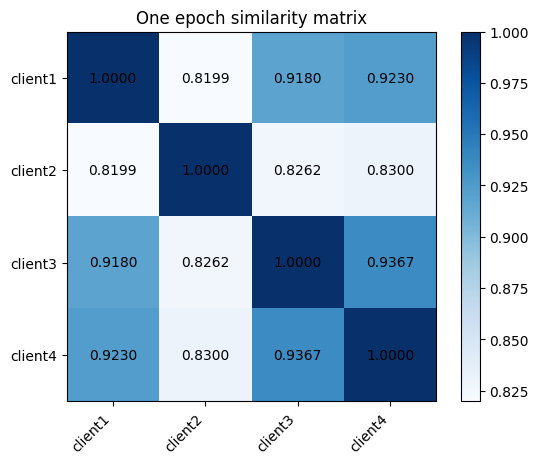

In [25]:
plot_similarity_matrix(trained_model_parameters,
                       model_names=['client1', 'client2', 'client3', 'client4'],
                       title='One epoch similarity matrix')

Number of parameters per model, (48846,)


array([[1.00000012, 0.66735429, 0.7690599 , 0.75027806],
       [0.66735429, 1.        , 0.68200254, 0.65577549],
       [0.7690599 , 0.68200254, 1.        , 0.76396668],
       [0.75027806, 0.65577549, 0.76396668, 1.00000012]])

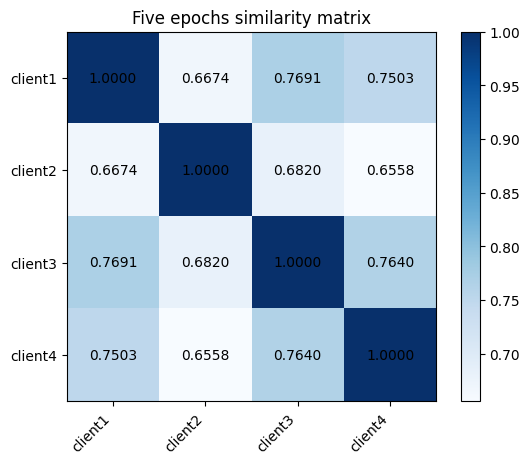

In [26]:
plot_similarity_matrix(trained_model_parameters_5_epochs,
                       model_names=['client1', 'client2', 'client3', 'client4'],
                       title='Five epochs similarity matrix')

**Question 6.3 Response:**

The cosine similarity between weights decreases as the number of training epochs increase.  

This could be because with more training, the clients are fitting the model more towards their own section of the data, causing the weights to diverge more from their initial starting state.

## 7. Federated training with Flower
---

The two basic blocks of synchronous server-client FL systems are:
- A client with some local training method and data---i.e., SGD. This is what we have built thus far.
- A server which coordinates training sends the federated model to clients at the start of each round and aggregates model updates at the end of each round.


![picture](https://drive.google.com/uc?id=1Db_Uys2QPFHW6cMranZ_QXo2vC0A_C-N)

While the variety of client local training methods is as wide as ML, server training varies depending on which **aggregation algorithm** combines the model updates and forms the new federated model. Flower refers to the component that controls the aggregation and train/test configuration as a **strategy**. For our labs, strategy and aggregation algorithms will be used interchangeably.

The strategy we shall use is [FedAvg](https://arxiv.org/abs/1602.05629):

$G^{r+1} = G^{r} + \eta \left( \sum_{k=1}^{m} p_k G^r_k \right)$,

where $G^{r+1}$ is the model for the next round, which is formed by applying a model update to the current round model $G^{r}$ weighted by the aggregation learning rate $\eta$. The model update is constructed by a sum of client models $G^{r}_k$ where each client model is weighted by $p_k$. The weight factor is usually set to $p_k = \tfrac{n_k}{N}$---the number of training examples held by said client divided by the example count of each client in the round $N = \sum_{k=1}^{m} n_k$.



---

**Question 7 (Part II ✅ | Part III/MPhil ✅):**

(You need to provide the answer with **code** for this question. Written argumentation is **strongly** recommended.)

Averaging models is meant to provide us with a reasonable compromise between the desired models of all clients involved. Given what you already know about the similarity of client models, we can test if this is true.
1. Write a function to compute the weighted average of two `NDArrays` objects while preserving the layer-structure. Use the FedAvg equation above with $p_k = \tfrac{n_k}{N}$.
2. Compute the average model of the client models above, both the one-epoch and multi-epoch ones.
3. Add the averaged models to the cosine-similarity matrices built above, how does it relate to the client models?

---

**Question 8 (Part III/MPhil ✅):**

(You need to provide the answer with **code** for this question. Written argumentation is **strongly** recommended.)


1. Repeat the procedure above but for layer-wise cosine similarity and plot the cosine similarity of the two clients client most similar and most disimillar to the averaged model (as determined by the five-epoch condition) using the one-epoch models.
2. How does the relationship change for the higher-epoch condition?

---

In [27]:
import numpy.typing as npt




def calculate_weighted_average(arr1:NDArrays, arr2:NDArrays):
    pass


def calculate_weighted_average(arrays: NDArrays,
                               weights: npt.NDArray):

    _arrays = np.array(arrays)
    # print(_arrays, weights)
    result = (np.tensordot(_arrays, weights, axes=(0,0)))
    return result

def calculate_weighted_average_across_layers(arrays:list[NDArrays],
                                             weights:npt.NDArray):
    weighted_average = []
    for layer_idx in range(len(arrays[0])):
        layer_parameters = [model_parameters[layer_idx] for model_parameters in arrays]
        weighted_average.append(
            calculate_weighted_average(layer_parameters, weights)
        )

    return weighted_average

# calculate_weighted_average_across_layers([a, b], weights)

number_of_examples = np.array(
    [federated_client_generator(str(i)).get_train_set_size() for i in clients])
weights = number_of_examples / sum(number_of_examples)

weighted_average_model_5 = calculate_weighted_average_across_layers(
    trained_model_parameters_5_epochs, weights)

weighted_average_model_1 = calculate_weighted_average_across_layers(
    trained_model_parameters,
    weights
)

INFO flwr 2025-02-10 21:09:14,512 | <ipython-input-9-2c3670f7beb9>:21 | cid: 3175
INFO:flwr:cid: 3175
/content/labs/common/femnist_dataset.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exper

Number of parameters per model, (48846,)


array([[1.00000012, 0.66735429, 0.7690599 , 0.75027806, 0.85348855],
       [0.66735429, 1.        , 0.68200254, 0.65577549, 0.93240701],
       [0.7690599 , 0.68200254, 1.        , 0.76396668, 0.85275978],
       [0.75027806, 0.65577549, 0.76396668, 1.00000012, 0.84312609],
       [0.85348855, 0.93240701, 0.85275978, 0.84312609, 1.        ]])

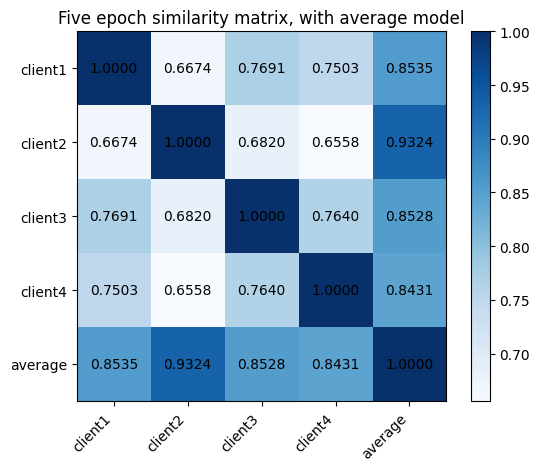

In [28]:
plot_similarity_matrix(
    trained_model_parameters_5_epochs + [weighted_average_model_5],
    model_names = ['client1','client2','client3','client4','average'],
    title = 'Five epoch similarity matrix, with average model'
)

Number of parameters per model, (48846,)


array([[0.99999994, 0.81993991, 0.91801685, 0.92299426, 0.93459502],
       [0.81993991, 1.        , 0.82623529, 0.82998985, 0.96006266],
       [0.91801685, 0.82623529, 1.        , 0.93666798, 0.93684799],
       [0.92299426, 0.82998985, 0.93666798, 1.        , 0.9412285 ],
       [0.93459502, 0.96006266, 0.93684799, 0.9412285 , 1.        ]])

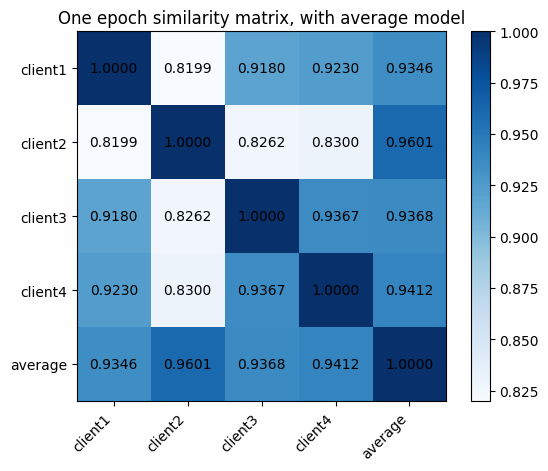

In [29]:
plot_similarity_matrix(
    trained_model_parameters + [weighted_average_model_1],
    model_names = ['client1','client2','client3','client4','average'],
    title = 'One epoch similarity matrix, with average model'
)

The pieces necessary for starting an FL simulation are now in play; we need to arrange them to fit the Flower API. First, we shall require a separate federated evaluation function which can be called outside the context of a specific client. It will use the centralised test set to be as simple as possible.

In [30]:
def get_federated_evaluation_function(
    batch_size: int,
    num_workers: int,
    model_generator: Callable[[], Module],
    criterion: Module,
    max_batches: int,
) -> Callable[[int, NDArrays, dict[str, Any]], tuple[float, dict[str, Scalar]]]:
    """Wrap the external federated evaluation function.

    It provides the external federated evaluation function with some
    parameters for the dataloader, the model generator function, and
    the criterion used in the evaluation.

    Parameters
    ----------
        batch_size (int): batch size of the test set to use.
        num_workers (int): correspond to `num_workers` param in the Dataloader object.
        model_generator (Callable[[], Module]):  model generator function.
        criterion (Module): PyTorch Module containing the criterion for evaluating the
        model.

    Returns
    -------
        Callable[[int, NDArrays, dict[str, Any]], tuple[float, dict[str, Scalar]]]:
            external federated evaluation function.
    """

    def federated_evaluation_function(
        server_round: int,
        parameters: NDArrays,
        fed_eval_config: dict[
            str, Any
        ],  # mandatory argument, even if it's not being used
    ) -> tuple[float, dict[str, Scalar]]:
        """Evaluate federated model on the server.

        It uses the centralized val set for sake of simplicity.

        Parameters
        ----------
            server_round (int): current federated round.
            parameters (NDArrays): current model parameters.
            fed_eval_config (dict[str, Any]): mandatory argument in Flower, can contain
                some configuration info

        Returns
        -------
            tuple[float, dict[str, Scalar]]: evaluation results
        """
        device: str = get_device()
        net: Module = set_model_parameters(model_generator(), parameters)
        net.to(device)

        full_file: Path = centralized_mapping
        dataset: Dataset = load_femnist_dataset(data_dir, full_file, "val")

        valid_loader = DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            drop_last=False,
        )

        loss, acc = test_femnist(
            net=net,
            test_loader=valid_loader,
            device=device,
            criterion=criterion,
            max_batches=max_batches,
        )
        return loss, {"accuracy": acc}

    return federated_evaluation_function


federated_evaluation_function = get_federated_evaluation_function(
    batch_size=test_config["batch_size"],
    num_workers=test_config["num_workers"],
    model_generator=network_generator,
    criterion=nn.CrossEntropyLoss(),
    max_batches=test_config["max_batches"],
)

In [31]:
def aggregate_weighted_average(metrics: list[tuple[int, dict]]) -> dict:
    """Combine results from multiple clients following training or evaluation.

    Parameters
    ----------
        metrics (list[tuple[int, dict]]): collected clients metrics

    Returns
    -------
        dict: result dictionary containing the aggregate of the metrics passed.
    """
    average_dict: dict = defaultdict(list)
    total_examples: int = 0
    for num_examples, metrics_dict in metrics:
        for key, val in metrics_dict.items():
            if isinstance(val, numbers.Number):
                average_dict[key].append((num_examples, val))
        total_examples += num_examples
    return {
        key: {
            "avg": float(
                sum([num_examples * metric for num_examples, metric in val])
                / float(total_examples)
            ),
            "all": val,
        }
        for key, val in average_dict.items()
    }

In [32]:
# Federated configuration dictionary
federated_train_config: dict[str, Any] = {
    "epochs": 5,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": 100,
}

The only challenge left is the FL simulation itself. In `Flower`, a `Server` object handles this for us by using `Ray` and spawning many heavyweight worker process.

Given the limited-resource scenario in which we find ourselves, we provide you with a slightly modified simulation function which uses a simple thread pool. Feel free to swap it out for the original simulation or replace it with your own implementation if so inclined.

> The server we use is not the default `Flower` server as it returns the model parameters from every single round in a `(round, NDArrays)` tuple.

In [33]:
def start_seeded_simulation(
    client_fn: Callable[[str], Client],
    num_clients: int,
    config: ServerConfig,
    strategy: Strategy,
    name: str,
    return_all_parameters: bool = False,
    seed: int = Seeds.DEFAULT,
    iteration: int = 0,
) -> tuple[list[tuple[int, NDArrays]], History]:
    """Wrap to seed client selection."""
    np.random.seed(seed ^ iteration)
    torch.manual_seed(seed ^ iteration)
    random.seed(seed ^ iteration)
    parameter_list, hist = flwr.simulation.start_simulation_no_ray(
        client_fn=client_fn,
        num_clients=num_clients,
        client_resources={},
        config=config,
        strategy=strategy,
    )
    save_history(home_dir, hist, name)
    return parameter_list, hist

In [34]:
num_rounds = 50
num_total_clients = 20

num_evaluate_clients = 0
num_clients_per_round = 5

initial_parameters = ndarrays_to_parameters(seed_model_params)


def run_simulation(
    # How long the FL process runs for:
    num_rounds: int = num_rounds,
    # Number of clients available
    num_total_clients: int = num_total_clients,
    # Number of clients used for train/eval
    num_clients_per_round: int = num_clients_per_round,
    num_evaluate_clients: int = num_evaluate_clients,
    # If less clients are overall available stop FL
    min_available_clients: int = num_total_clients,
    # If less clients are available for fit/eval stop FL
    min_fit_clients: int = num_clients_per_round,
    min_evaluate_clients: int = num_evaluate_clients,
    # Function to test the federated model performance
    # external to a client instantiation
    evaluate_fn: (
        Callable[
            [int, NDArrays, dict[str, Scalar]],
            tuple[float, dict[str, Scalar]] | None,
        ]
        | None
    ) = federated_evaluation_function,
    # Functions to generate a config for client fit/evaluate
    # by-default the same config is shallow-copied to all clients in Flower
    # this version simply uses the configs defined above
    on_fit_config_fn: Callable[
        [int], dict[str, Scalar]
    ] = lambda _x: federated_train_config,
    on_evaluate_config_fn: Callable[[int], dict[str, Scalar]] = lambda _x: test_config,
    # The "Parameters" type is merely a more packed version
    # of numpy array lists, used internally by Flower
    initial_parameters: Parameters = initial_parameters,
    # If this is set to True, aggregation will work even if some clients fail
    accept_failures: bool = False,
    # How to combine the metrics dictionary returned by all clients for fit/eval
    fit_metrics_aggregation_fn: Callable | None = aggregate_weighted_average,
    evaluate_metrics_aggregation_fn: Callable | None = aggregate_weighted_average,
    federated_client_generator: Callable[
        [str], flwr.client.NumPyClient
    ] = federated_client_generator,
    # Aggregation learning rate for FedAvg
    server_learning_rate: float = 1.0,
    server_momentum: float = 0.0,
) -> tuple[list[tuple[int, NDArrays]], History]:
    """Run a federated simulation using Flower."""
    log(INFO, "FL will execute for %s rounds", num_rounds)

    # Percentage of clients used for train/eval
    fraction_fit: float = float(num_clients_per_round) / num_total_clients
    fraction_evaluate: float = float(num_evaluate_clients) / num_total_clients

    strategy = FedAvg(
        fraction_fit=fraction_fit,
        fraction_evaluate=fraction_evaluate,
        min_fit_clients=min_fit_clients,
        min_evaluate_clients=min_evaluate_clients,
        min_available_clients=min_available_clients,
        on_fit_config_fn=on_fit_config_fn,
        on_evaluate_config_fn=on_evaluate_config_fn,
        evaluate_fn=evaluate_fn,
        initial_parameters=initial_parameters,
        accept_failures=accept_failures,
        fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
        evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
        server_learning_rate=server_learning_rate,
        server_momentum=server_momentum,
    )
    # resetting the seed for the random selection of clients
    # this way the list of clients trained is guaranteed to be always the same

    cfg = ServerConfig(num_rounds)

    def simulator_client_generator(cid: str) -> Client:
        return federated_client_generator(cid).to_client()

    parameters_for_each_round, hist = start_seeded_simulation(
        client_fn=simulator_client_generator,
        num_clients=num_total_clients,
        config=cfg,
        strategy=strategy,
        name="fedavg",
        return_all_parameters=True,
        seed=Seeds.DEFAULT,
    )
    return parameters_for_each_round, hist

In [ ]:
parameters_for_each_round, hist = run_simulation()

INFO flwr 2025-02-10 21:09:16,276 | <ipython-input-34-621c42aa986e>:55 | FL will execute for 50 rounds
INFO:flwr:FL will execute for 50 rounds
INFO flwr 2025-02-10 21:09:16,284 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=50, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=50, round_timeout=None)
INFO flwr 2025-02-10 21:09:16,288 | server_returns_parameters.py:81 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2025-02-10 21:09:16,290 | server_returns_parameters.py:273 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 2025-02-10 21:09:16,295 | server_returns_parameters.py:84 | Evaluating initial parameters
INFO:flwr:Evaluating initial parameters
 11%|█         | 100/891 [00:03<00:31, 25.26it/s]
INFO flwr 2025-02-10 21:09:20,380 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 413.684264659

In [ ]:
log(
    INFO,
    "Size of the list with the model parameters: %s",
    len(parameters_for_each_round),
)

---

**Question 9 (Part II ✅ | Part III/MPhil ✅):**

(You must provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

Now that an entire FL experiment can be trained, it is worth considering the relationship between the FL model across rounds. If we consider the final model $\theta^N$ obtained after $N$ rounds to be the optimal model $\theta^*$, we can ask how optimization step contributed to reaching $\theta^*$.

1. Run an FL simulation for at-least 50 rounds.
2. Build a function which reconstitutes the update that must have been applied to model $\theta^t$ in order to obtain $\theta^{t+1}$, assume the `server_learning_rate` was 1.0. We shall call this update $g_t$ and treat it as a pseudo-gradient.
3. For each round plot the cosine similarity between $g_t$ and the direction of improvement towards $\theta^{*}$ calculated as $\theta^{*} - \theta_t$.
4. What do you observe from the plots? Does every update point in the direction of the final model? If not, why do you think that is?

---

**Question 10 (Part III/MPhil ✅):**

(You must provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

 and then for

1.   Read about server momentum in FL [here](https://arxiv.org/abs/2003.00295) and repeat the previous experiments using `server_learning_rate=1.0` and `server_momentum=0.9`. Discuss how the momentum impacts the direction of optimization.

---

Number of rounds: 50


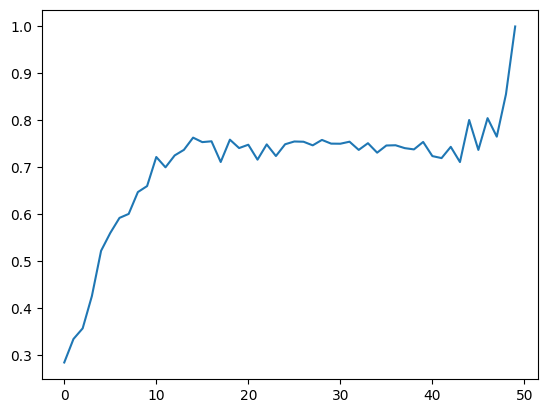

In [38]:
print("Number of rounds:",  len(parameters_for_each_round) - 1)

def difference_in_parameters(params1, params2):
    return [i - j for i, j in zip(params1, params2)]

reconstituted_gradients = [difference_in_parameters(i[1], j[1])
    for i, j in zip(parameters_for_each_round[:-1], parameters_for_each_round[1:])]

last_model_parameters = parameters_for_each_round[-1][1]
directions_of_improvement = [
    difference_in_parameters(i[1], last_model_parameters)
    for i in parameters_for_each_round[:-1]
]


cosine_similarities = [
    get_parameters_cosine_similarity(
        reconstituted_gradient,
        direction_of_improvement
    )
    for reconstituted_gradient, direction_of_improvement in zip(
        reconstituted_gradients, directions_of_improvement)
]

plt.plot(cosine_similarities)

**Q9.4 Response**  

Not every update points in the direction of the model. When training a (typical centralised) neural network, the loss would tend to bounce around a little bit before convergence, due to the network getting stuck in local minima. Possibly in the federated case, different clients can get stuck inside their own local minima before getting "pulled out" by other models during the averaging phase.

(c) 2024 Alexandru-Andrei Iacob, Lorenzo Sani